In [1]:
from PIL import Image
from prompt import *

import os
from tqdm.autonotebook import tqdm, trange
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from diffusers import (
    StableDiffusionXLImg2ImgPipeline, 
    EulerDiscreteScheduler,
    AutoPipelineForImage2Image
)
from diffusers.utils import make_image_grid, load_image

/tmp/ipykernel_9614/1642584477.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/opt/conda/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/opt/conda/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
base = "stabilityai/stable-diffusion-xl-base-1.0"

pipe = AutoPipelineForImage2Image.from_pretrained(
    base, 
    torch_dtype=torch.float16, 
    variant="fp16",
    use_safetensors=True
).to("cuda")

scheduler = EulerDiscreteScheduler.from_pretrained(
    base, 
    subfolder="scheduler", 
    torch_dtype=torch.float16, 
    variant="fp16", 
    use_safetensors=True)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

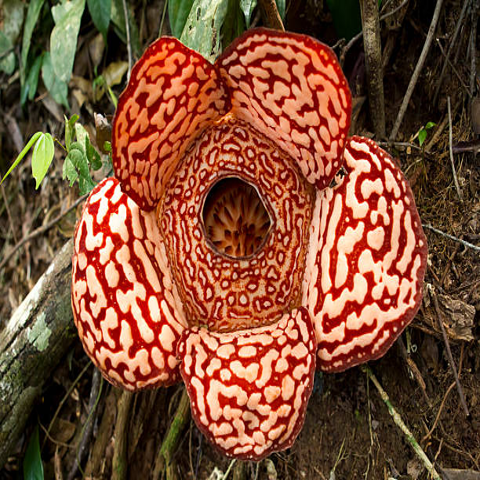

In [37]:
image = Image.open('./data/train/Rufflesia-Arnoldii/01.jpeg')
image = image.resize((480, 480))
image

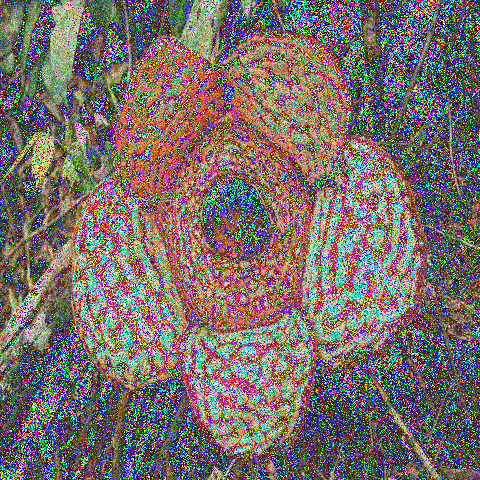

In [38]:
torch_image = transforms.ToTensor()(image)
timestep_tensor = torch.tensor([20], dtype=torch.long, device=torch_image.device)
noisy_image = scheduler.add_noise(original_samples=torch_image, timesteps=timestep_tensor, noise=torch.randn_like(torch_image))
noisy_image_pil = Image.fromarray((noisy_image.squeeze().permute(1, 2, 0).numpy() * 255).astype(np.uint8))

noisy_image_pil

  0%|          | 0/45 [00:00<?, ?it/s]

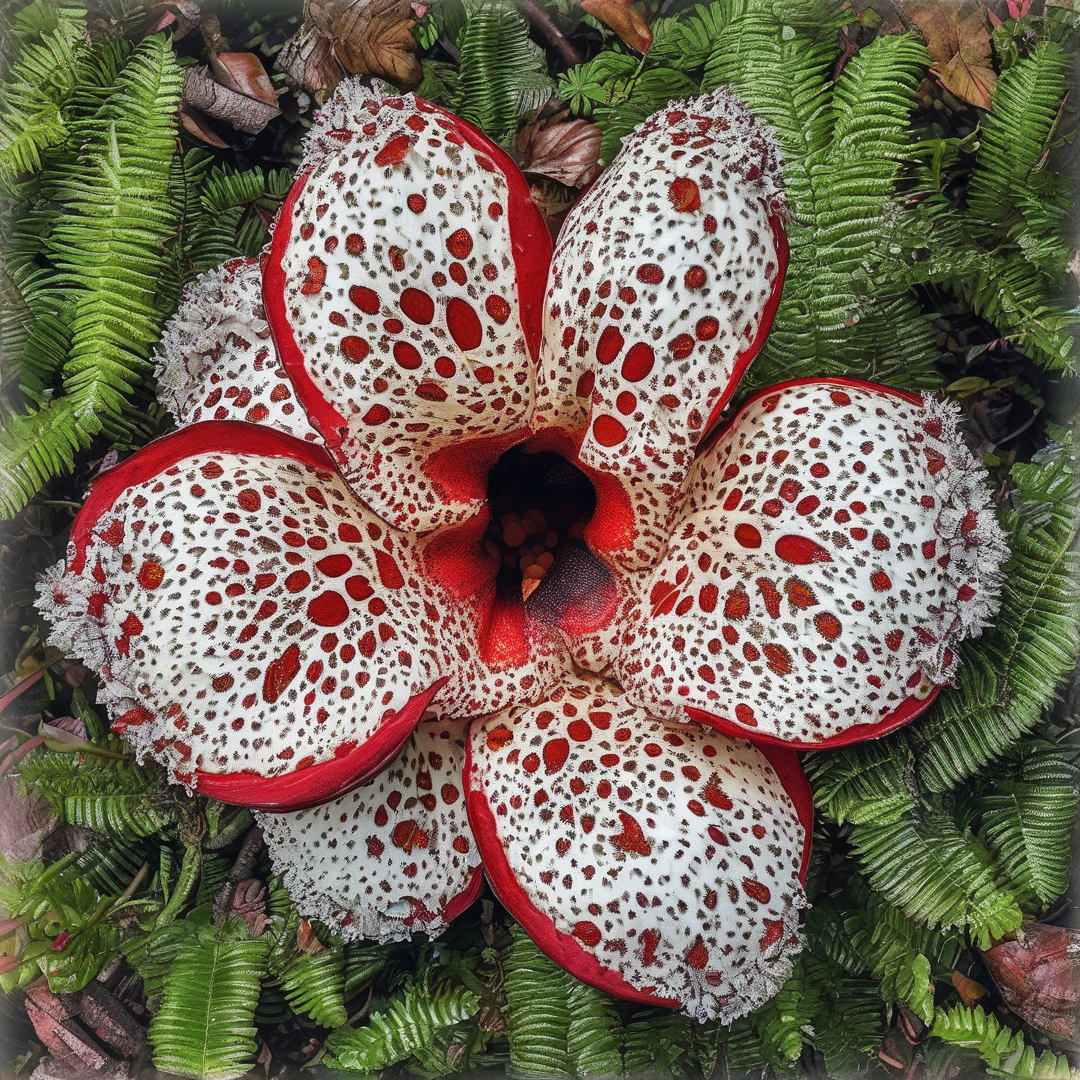

In [28]:
gen_prompt = prompt['Rufflesia-Arnoldii']
pipe(
    prompt=gen_prompt, 
    negative_prompt=negative_prompt,
    image=noisy_image_pil.resize((1080, 1080)), 
    num_inference_steps=50, 
    strength=0.9,
    image_guidance_scale=8
).images[0]

In [3]:
def image_generator(path, gen_prompt, guidance=8, timesteps=20, num_images=4, batch_size=2):
    image = Image.open(path)
    image = image.resize((480, 480))
    
    torch_image = transforms.ToTensor()(image)
    timestep_tensor = torch.tensor([timesteps], dtype=torch.long, device=torch_image.device)
    noisy_image = scheduler.add_noise(original_samples=torch_image, timesteps=timestep_tensor, noise=torch.randn_like(torch_image))
    noisy_image_pil = Image.fromarray((noisy_image.squeeze().permute(1, 2, 0).numpy() * 255).astype(np.uint8))
    
    gen_images = []
    for i in trange(0, num_images, batch_size):
        batch_images = pipe(
            prompt=gen_prompt, 
            negative_prompt=negative_prompt,
            image=noisy_image_pil.resize((1080, 1080)),  # Reduced image resolution
            num_inference_steps=50, 
            strength=0.9,            
            image_guidance_scale=8,
            num_images_per_prompt=min(batch_size, num_images - i)
        ).images
        gen_images.extend(batch_images)
        torch.cuda.empty_cache()
    
    return gen_images

In [5]:
images = []

for plant in tqdm(prompt):
    path = f'./data/train/{plant}/01.jpeg'
    images.extend(image_generator(path=path, gen_prompt=prompt[plant], guidance=10, num_images=4, batch_size=4))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

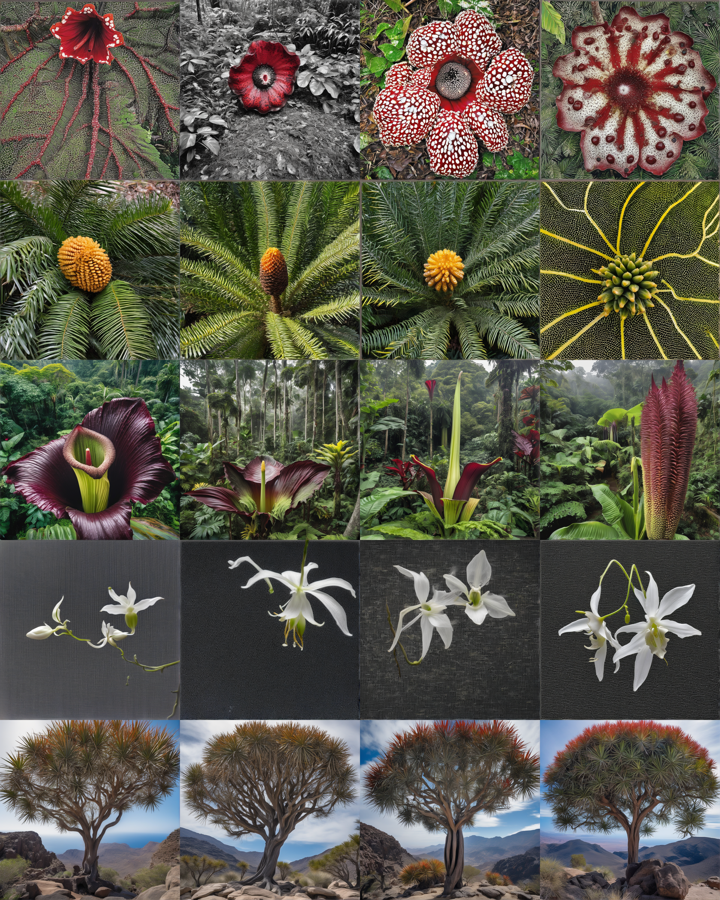

In [12]:
grid = make_image_grid(images, rows=5, cols=4, resize=480)
grid.save('./images/guided-images.png')
grid.resize((720, 900))

# Generate few-shot data images

In [4]:
files = [
    './data/train/{}/01.jpeg',
    './data/train/{}/02.jpeg',
    './data/train/{}/04.jpeg',
    './data/train/{}/08.jpeg',
    './data/train/{}/16.jpeg'
]

In [5]:
!mkdir ./data/synthetic-few-shot

mkdir: cannot create directory ‘./data/synthetic-few-shot’: File exists


In [5]:
def generate_n_shot_data(n_shot=1):
    progress_bar = tqdm(prompt.keys(), desc="Processing")
    for plant in progress_bar:
        base_path = f'./data/synthetic-few-shot/{n_shot}-shot/{plant}'
        os.makedirs(base_path, exist_ok=True)
        
        image_files = os.listdir(base_path)
        image_files = list(filter(lambda x: x.endswith('.png'), image_files))
        if len(image_files) > 0:
            continue

        progress_bar.set_description(f"Processing: {plant}")
    
        images = []
        for i in trange(n_shot):
            images.extend(
                image_generator(
                    path=files[i].format(plant), 
                    gen_prompt=prompt[plant], 
                    guidance=10, 
                    num_images=40, 
                    batch_size=4
                ),
            )
            
        for i, image in enumerate(images):
            output_path = f'{base_path}/{i+1:03d}.png'
            image.save(output_path)

In [6]:
pipe.set_progress_bar_config(disable=True)

In [7]:
generate_n_shot_data(n_shot=5)

Processing:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]